# Subset Gridded Static Inputs

To launch this notebook interactively in a Jupyter notebook-like browser interface, please click the "Launch Binder" button below. Note that Binder may take several minutes to launch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydroframe/subsettools-binder/HEAD?labpath=subsettools%2Fsubset_static_inputs.ipynb)

There are a wide variety of static files available through the HydroData Database. You can learn more about them through the HydroData documentation [here](https://hf-hydrodata.readthedocs.io/en/latest/). Static datasets are generally associated with hydro-geofabrics that have been developed for national model runs. They include ParFlow model inputs like topographic slopes and subsurface conductivity but also additional variables like elevation or distance to streams.  Most static datasets are associated with the two national ParFlow Models ([ParFlow CONUS1.0](https://hydroframe.org/parflow-conus1) and [ParFlow CONUS2.0 ](https://hydroframe.org/parflow-conus2)) 

You can use the [`subset_static`](https://hydroframesubsettools.readthedocs.io/en/api-fix/autoapi/subsettools/index.html#subsettools.subset_static) function to automatically subset a complete set of ParFlow model inputs. 
- Slope in the east/west direction (`slope_x`)
- Slope in the north/south direction (`slope_y`)
- Subsurface units indicator file (`pf_indicator`)
- Mannings roughness coefficients (`mannings`)
- Depth to bedrock (`pf_flowbarrier`)
- Long term average preciptation minus evaporation (i.e. recharge) (`pme`)
- Steady state pressure head used to initialize transient simulations (`ss_pressure_head`)
  
Or you can modify this function or use the [`hf_hydrodata.get_gridded_data`](https://hf-hydrodata.readthedocs.io/en/latest/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_gridded_data) function to subset any gridded file from the HydroData Catalog. 

Subsetting pressure files from one of the national simulations (i.e. to get initial conditions for a watershed model) is a slightly different process because it involves accessing timeseries outputs from HydroData. We provide an example of how to do that here too. 

Note that the SubsetTools and HydroData API tools do not provide any re-gridding options. Data will be returned at the resolution of the initial dataset which is being subset.

#### Things to determine before you start
1. Before you start you should browse the [data catalog](https://hf-hydrodata.readthedocs.io/en/latest/available_datasets.html#static-model-inputs-and-domain-files) and determine which static input dataset you would like to subset. 
2. Take note of the dataset name and the grid that it is available on as you will need this information for your subsetting. 
3. If you are subsetting a pressure file from a simulation also take note of the start and end dates of the dataset as well as the temporal resolution (e.g. hourly, daily), as these will set the limits of what you can subset.

## 1.  Setup 

In all examples you will need to import the following packages and register your pin in order to have access to the HydroData datasets

Refer to the [getting started](https://hydroframesubsettools.readthedocs.io/en/latest/getting_started.html) instructions for creating your pin if you have not done this already.

In [ ]:
import subsettools as st
import hf_hydrodata as hf
from parflow.tools.io import read_pfb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hf.register_api_pin("your_email", "your_pin")

## 2.0 Subset the static input variables
There are two approaches to subsetting static data:
-  The `subset_static` function will automatically get the forcing data for 7 static input variables listed above and will write the data as pfb files into your output directory to be ready for a ParFlow run. You can modify this function to get a smaller list of variables if you would like or to select any static variable that is included with a dataset even if its not in the default variable list.
- The `gridded.get_gridded_data` function provides more direct access to the HydroData API and can return any subset variables of interest as a numpy array.  

### 2.1 Subset static inputs with the `subset_static` function
This approach is recommended if you are planning on using the static inputs for a ParFlow run. By default, `subset_static` will get the data for 7 static input variables (API reference [here](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/index.html#subsettools.subset_static)) and write them out as PFBs (ParFlow Binary Files) for a ParFlow-CLM simulation. (*NOTE: Depending on the configuration of your ParFlow run not all of these inputs are required, refer to the ParFlow run tutorials for more information on this*) 

In addition to writing the files out the function returns a dictionary where the keys are static input variable names (e.g. 'slope_x', 'pf_flowbarrier', ...) and the values are the filepaths where the subset data for that variable were written. We will show how to use these paths to load the data into an array and plot them later in this tutorial.

**NOTE:** *Some datasets might not contain all 7 static input variables. In that case, the `subset_static` function is going to raise an error for any variables that are not supported by the dataset. You can check [here](https://hf-hydrodata.readthedocs.io/en/latest/available_data.html) which variables are contained in each dataset.* 

**NOTE:** *The ij indices must match the grid for the datasets you are subsetting. You can see what grid each dataset is available on in the dataset documentation*

In [2]:
# calculate the HUC bounds
ij_huc_bounds, mask = st.define_huc_domain(hucs=["07080205"], grid="conus1")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (2107, 929, 2247, 1016)


In [ ]:
# Example grabbing all static input variables for the CONUS1 domain
# Note that we need to remove "mannings" and "pf_flowbarrier" from the default list,
# as they are not supported in the conus1_domain dataset.
static_filepaths = st.subset_static(
    ij_huc_bounds,
    dataset="conus1_domain",
    write_dir="/path/to/your/write/directory",
    var_list=("slope_x", "slope_y", "pf_indicator", "pme", "ss_pressure_head"),
)

/tmp/ipykernel_17134/3315558362.py:4: DeprecationWarning: Note that for subsettools versions >= 2.0.0, this function will raise a ValueError if a variable in var_list is not supported in the dataset. (In older versions, it just printed an error message and continued executing normally). You can check in the HydroData documentation which variables are contained in each dataset (https://hf-hydrodata.readthedocs.io/en/latest/available_data.html).
  static_filepaths = st.subset_static(


Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
Wrote pme.pfb in specified directory.
Wrote ss_pressure_head.pfb in specified directory.


### 2.2 Subset initial pressure data using the `subset_press_init` function
If you want to subset a single pressure file to use as an initial pressure for a ParFlow simulation we recommend using the `subset_press_init`. This function will subset the simulated pressure data one hour before midnight on the day before the date specified (i.e. the last pressure file available before the date specified by the user).  The subset values will be written out as a PFB (ParFlow Binary File) that you can use to start your run from. 

By default the function will assume UTC time when subsetting but you can swap to your local timezone using the timezone argument in which case it will select the last pressure file before midnight on your specified date in that local timezone. 

In this example we are subsetting a pressure file from from the modern CONUS1 baseline simulation described [here](https://hf-hydrodata.readthedocs.io/en/latest/gen_conus1_baseline_85.html).  You can see a list of other ParFlow simulations that you can use to start from [here](https://hf-hydrodata.readthedocs.io/en/latest/available_datasets.html#parflow-simulation-outputs).

**NOTE**: *You can also start your run from a steady state pressure field that is associated with each domain. you will get this returned from the `subset_static` function so you only need this step if you are wanting to start from a different pressure field.*

In [ ]:
press_init_filepath = st.subset_press_init(
    ij_huc_bounds,
    dataset="conus1_baseline_mod",
    date="2005-12-15",
    write_dir="/path/to/your/write/directory",
    time_zone="EST",
)

UTC Date: 2005-12-15 05:00:00
Wrote ./conus1_baseline_mod_2005.12.15:05.00.00_UTC0_press.pfb in specified directory.


### 2.3 Subset data using `hf.get_gridded_data` function

The [`hf.get_gridded_data`](https://hf-hydrodata.readthedocs.io/en/latest/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_gridded_data) function is a general function to extract any gridded data from HydroData. Here we illustrate how to use it grab out a set of static input variables. Here we show how to use this approach to grab out a single column of data but the function works the same if you provide it a bounding box. 

Note that this will just return the data as NumPy arrays and will not write them out for a ParFlow run so if you use this option and want to run ParFlow some additional steps will be required to write the data out. 

**NOTE:** *Unlike st.subset_static, hf.get_gridded_data is going to throw an error for variables that do not exist (e.g. mannings for conus1_domain).*


In [5]:
# list the variables that you would like to extract
static_vars = (
    "slope_x",
    "slope_y",
    "pf_indicator",
    "pme",
    "ss_pressure_head",
)

static_data = {}
for var in static_vars:
    options = {"dataset": "conus1_domain",
               "variable": var,
               "period": "static",
               "file_type": "pfb",
               "grid_bounds": ij_huc_bounds
               }
    static_data[var] = hf.get_gridded_data(options)
    print(f"{var} loaded:", static_data[var].shape)

slope_x loaded: (87, 140)
slope_y loaded: (87, 140)
pf_indicator loaded: (5, 87, 140)
pme loaded: (5, 87, 140)
ss_pressure_head loaded: (5, 87, 140)


### 2.4 Subset initial pressure data using `hf.get_gridded_data` function

We can also use the `hf.get_gridded_data` function to get initial pressure data as well. Note that we cannot provide a time-zone argument through this function, as we did with `st.subset_press_init`.

In [6]:
options = {"dataset": "conus1_baseline_mod",
           "variable": "pressure_head",
           "file_type": "pfb",
           "period": "hourly",
           "grid_bounds": ij_huc_bounds,
           "start_time": "2005-12-15",
           "grid": "conus1"
}
initial_press = hf.get_gridded_data(options).squeeze()
print(f"Initial pressure loaded:", initial_press.shape)

Initial pressure loaded: (5, 87, 140)


## 3.0 Visualize the data 
If you use the `subset_static` function, data will need to be read in first using the `read_pfb` function. If you use `get_gridded_data` the data are already available as a numpy array.

### 3.1 loading and visualizing data that was written out using the `subset_static` function

Here we use the `read_pfb` function [from PFTools](https://parflow.readthedocs.io/en/latest/python/tutorials/pfb.html#loading-pfb-from-python)  to read the subset data in and plot it. We will plot the indicator file and the initial pressure data over the whole bounding box. By replacing the filepath in the code below, we can plot any static input or the initial pressure data.

Text(0.5, 1.0, 'Initial pressure (m)')

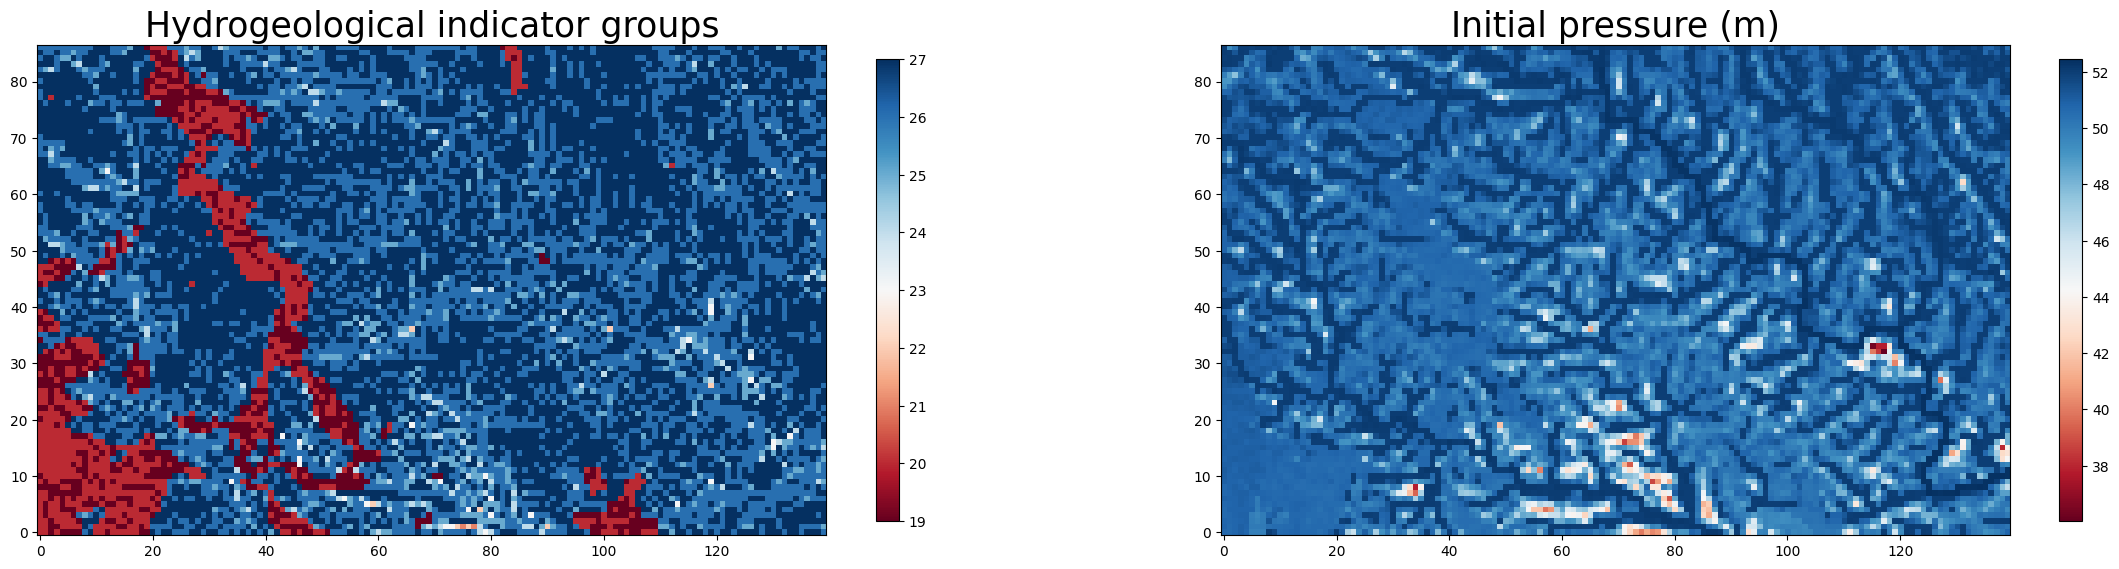

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(28, 10))

ax0 = axs[0]
filename = static_filepaths["pf_indicator"]
data = read_pfb(filename)[0]
im0 = ax0.imshow(data, cmap="RdBu", origin='lower')
colorbar1 = fig.colorbar(im0, ax=ax0, shrink=0.6)
ax0.set_title(f'Hydrogeological indicator groups', fontsize = 25)

ax1 = axs[1]
filename = press_init_filepath
data = read_pfb(filename)[0] # pick the bottom layer of the pressure data
im1 = ax1.imshow(data, cmap = "RdBu", origin='lower')
colorbar1 = fig.colorbar(im1, ax=ax1, shrink=0.6)
ax1.set_title(f'Initial pressure (m)', fontsize = 25)

### 3.2 Visualize data that was subset using `hf.get_gridded_data`

Here we just visualize the same data directly from the numpy arrays returned by the function in sections 2.3 and 2.4.

Text(0.5, 1.0, 'Initial pressure (m)')

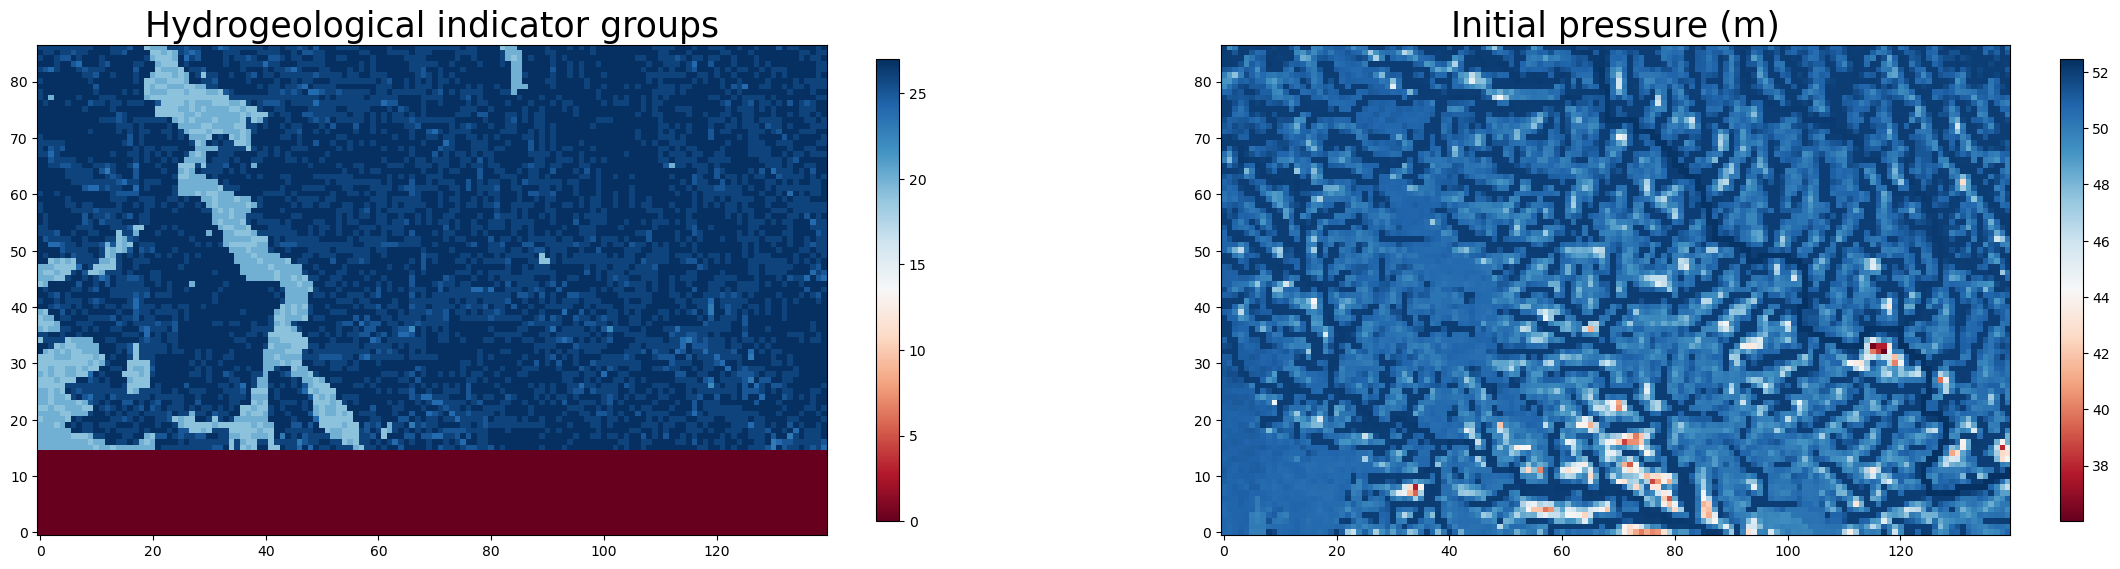

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(28, 10))

ax0 = axs[0]
data = static_data["pf_indicator"][0]
im0 = ax0.imshow(data, cmap="RdBu", origin='lower')
colorbar1 = fig.colorbar(im0, ax=ax0, shrink=0.6)
ax0.set_title(f'Hydrogeological indicator groups', fontsize = 25)

ax1 = axs[1]
data = initial_press[0] # pick the bottom layer of the pressure data
im1 = ax1.imshow(data, cmap = "RdBu", origin='lower')
colorbar1 = fig.colorbar(im1, ax=ax1, shrink=0.6)
ax1.set_title(f'Initial pressure (m)', fontsize = 25)

## 4. Cite the data sources

Please make sure to cite all data sources that you use. We will use the `get_citations` function, which takes as an argument a dataset name and returns citation information about that dataset:

In [3]:
hf.get_citations("conus2_domain")

'Inputs for baseline CONUS2 ParFlow Simulations\nNo paper references available.\n'

In [4]:
hf.get_citations("conus1_baseline_mod")

'Modern CONUS1 simulations WY 2003-2006\n  Source: https://doi.org/10.5194/gmd-14-7223-2021\n'